# CNNs for flower detection

In [4]:
import numpy as np  
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model
from glob import glob
import pandas as pd
from sklearn.model_selection import train_test_split

IMG_SIZE = 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

Load and preprocess the data

In [6]:
images = glob('data/flowers_data/flowers/*/*.jpg')    

In [7]:
data = pd.DataFrame({'filepath': images})
data['label'] = data['filepath'].apply(lambda x: x.split('/')[-2])  
data.head()

,filepath,label
0,data/flowers_data/flowers/sunflower/2979297519...,sunflower
1,data/flowers_data/flowers/sunflower/1462371969...,sunflower
2,data/flowers_data/flowers/sunflower/5293283002...,sunflower
3,data/flowers_data/flowers/sunflower/6074427492...,sunflower
4,data/flowers_data/flowers/sunflower/164671753_...,sunflower


In [8]:
flower_classes = data['label'].unique()
data['label_bin'] = data['label'].apply(lambda x: np.where(flower_classes == x)[0][0])
data.head()

,filepath,label,label_bin
0,data/flowers_data/flowers/sunflower/2979297519...,sunflower,0
1,data/flowers_data/flowers/sunflower/1462371969...,sunflower,0
2,data/flowers_data/flowers/sunflower/5293283002...,sunflower,0
3,data/flowers_data/flowers/sunflower/6074427492...,sunflower,0
4,data/flowers_data/flowers/sunflower/164671753_...,sunflower,0


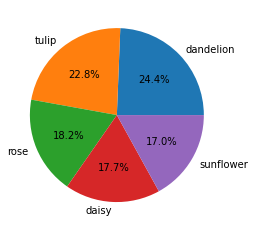

In [9]:
count = data['label'].value_counts()
plt.pie(count.values, labels=count.index, autopct='%1.1f%%')
plt.show()

Display parts of the dataset

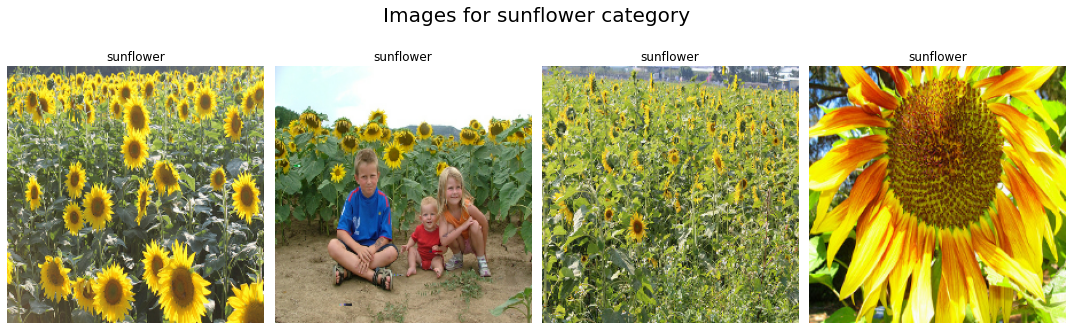

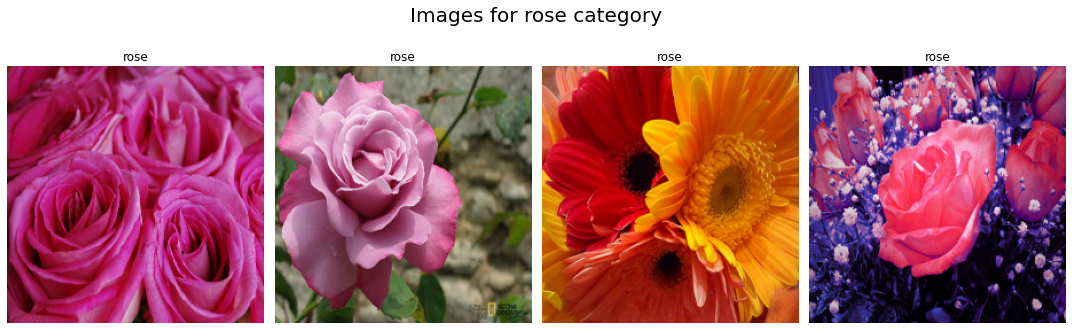

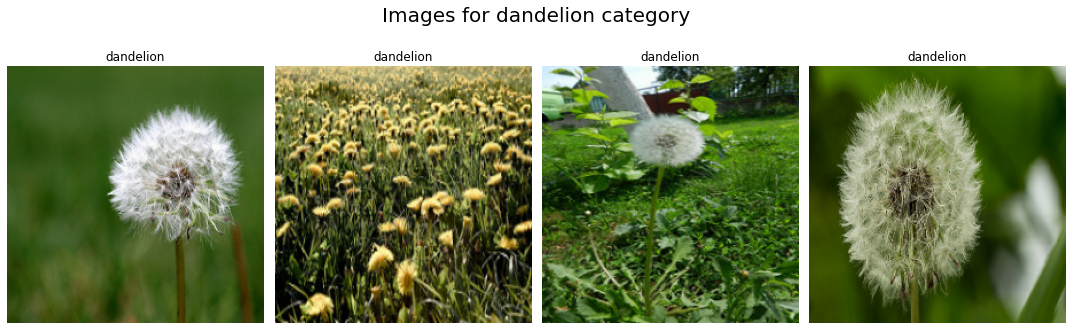

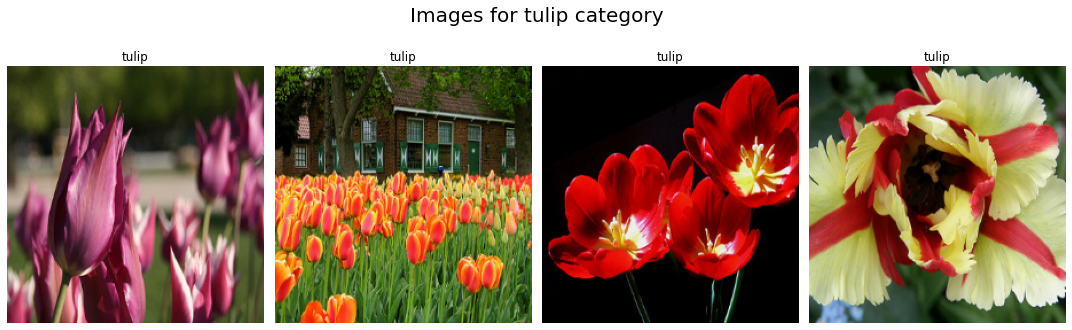

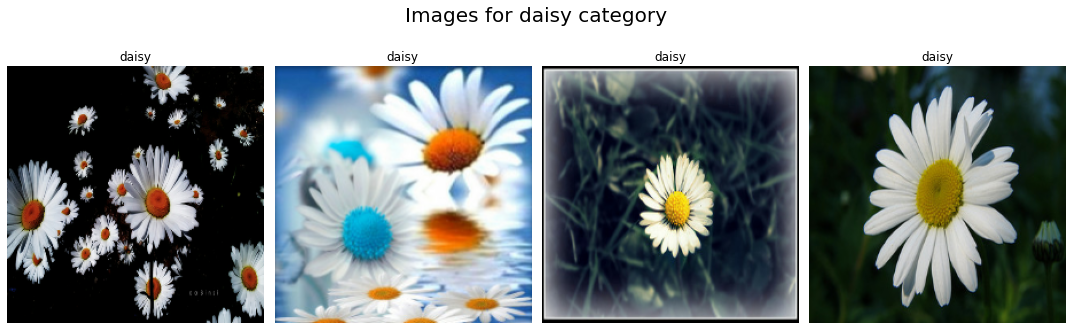

In [10]:
for cat in data['label'].unique():
    temp = data[data['label'] == cat]
    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category', fontsize=20)
    
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index_value = index_list[index]
        
        image_path = data.loc[index_value, 'filepath']
        img = tf.io.read_file(image_path)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
        img = tf.cast(img, tf.float32) / 255.0  # Normalize image
        
        ax[i].imshow(img)
        ax[i].set_title(cat)  
        ax[i].axis('off') 

    plt.tight_layout()
    plt.show()

Dataset augmentation to make the model robuster

In [11]:
def decode_and_augment_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.image.random_flip_left_right(img)  # Random horizontal flip
    img = tf.image.random_brightness(img, max_delta=0.2)  # Random brightness
    img = tf.image.random_contrast(img, lower=0.8, upper=1.2)  # Random contrast
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    return img, label

def decode_image(filepath, label=None):
    img = tf.io.read_file(filepath)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32) / 255.0  # Normalize
    return img, label

In [12]:
features = data['filepath']
target = data['label_bin']

X_train, X_val, Y_train, Y_val = train_test_split(features, target, test_size=0.2, random_state=10)

In [13]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_and_augment_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

Build the model

In [14]:
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),    
        Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
        Flatten(),
        Dense(512),
        Activation('relu'),
        Dense(5, activation="softmax")
    ])

    return model

In [15]:
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')
    
    plt.show()

In [16]:
def predict_image(model, img_path, class_names):
    img = load_img(img_path, target_size=(224, 224))
    img_array = np.expand_dims(np.array(img) / 255.0, axis=0)
    
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    
    print(f"Predicted Class: {predicted_class}")

In [17]:
model = build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 112, 112, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 112, 112, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0

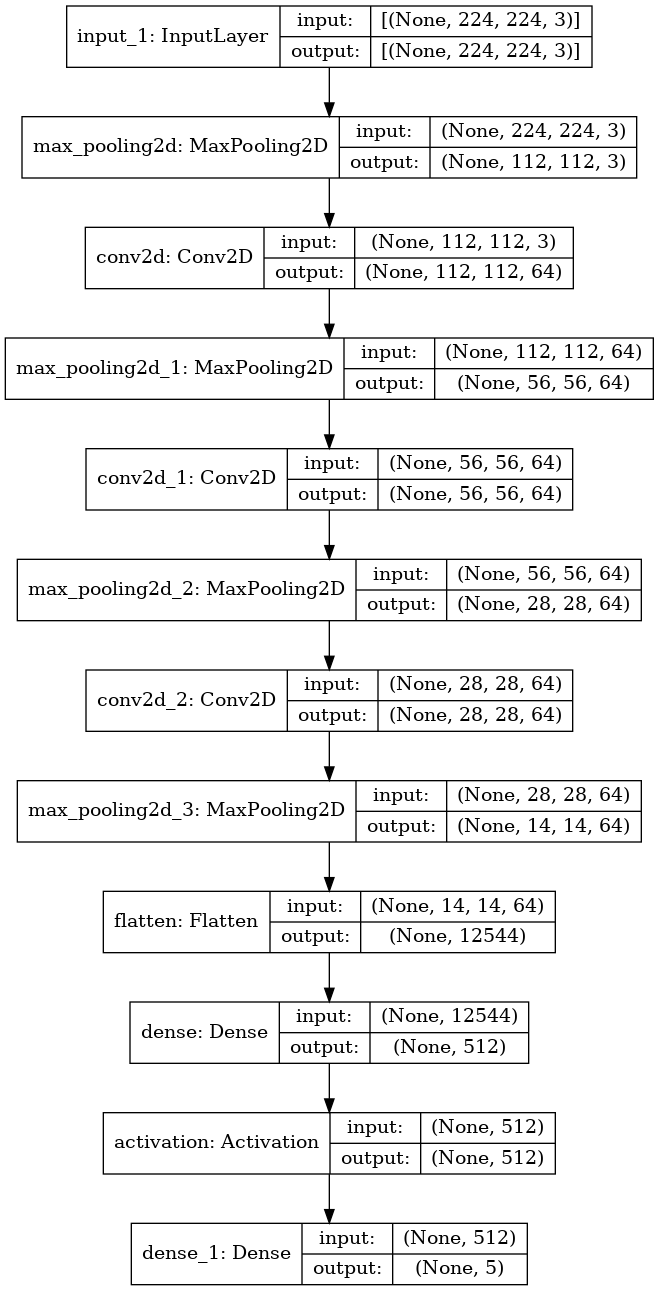

In [18]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Train the model

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.3876 - loss: 1.4354 - val_accuracy: 0.5938 - val_loss: 1.0452
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5788 - loss: 1.0696 - val_accuracy: 0.6215 - val_loss: 0.9606
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.6160 - loss: 0.9504 - val_accuracy: 0.6713 - val_loss: 0.8830
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 994ms/step - accuracy: 0.6816 - loss: 0.8410 - val_accuracy: 0.6910 - val_loss: 0.8687
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 111s 1s/step - accuracy: 0.7202 - loss: 0.7614 - val_accuracy: 0.6921 - val_loss: 0.8572
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 991ms/step - accuracy: 0.7464 - loss: 0.6597 - val_accuracy: 0.6412 - val_loss: 0.9987
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 107s 988ms/step - accuracy: 0.7782 - loss: 0.6035 - val_accuracy: 0.6586 - val_loss: 1.0168
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 108s 998ms/step - accuracy: 0.7956 - loss: 0.533

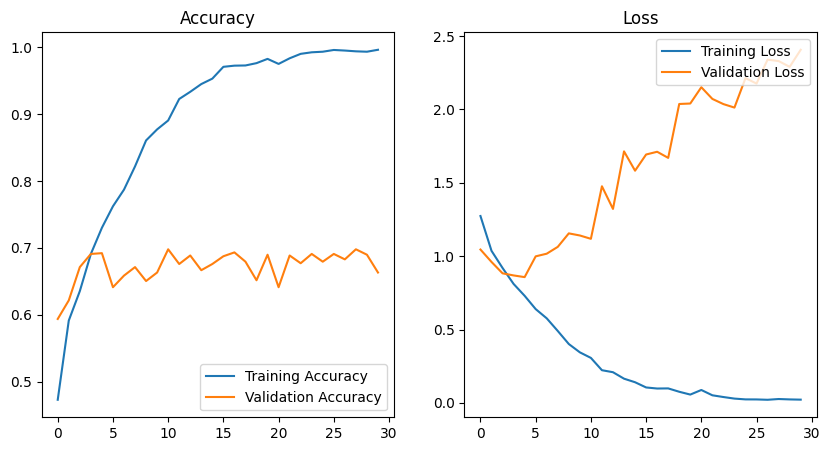

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

history = model.fit(train_ds, epochs=30, validation_data=val_ds, callbacks=callbacks)

plot_training(history)

Test the model

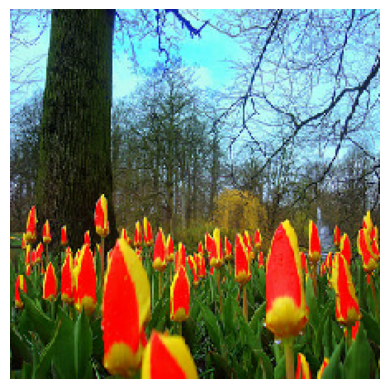

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Predicted Class: tulip


In [107]:
# Load the best model

best_model = load_model('best_model.keras')

class_names = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

predict_image(best_model, data.iloc[3024]['filepath'], class_names)